# Creating a Classification Model

In this exercise, you will implement a classification model that uses features of a flight to predict whether or not it will be late.

## Import Spark SQL and Spark ML Libraries

First, import the libraries you will need:

In [29]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler

print("Libraries imported!")

StatementMeta(sparkyh4u3ae, 2, 28, Finished, Available)

Libraries imported!


### Load Source Data
The data for this exercise is provided as a CSV file containing details of flights that has already been cleaned up for modeling. The data includes specific characteristics (or *features*) for each flight, as well as a *label* column indicating whether or not the flight was late (a flight with an arrival delay of more than 25 minutes is considered *late*).

You will load this data into a dataframe and display it.

In [5]:
flightSchema = StructType([
  StructField("DayofMonth", IntegerType(), False),
  StructField("DayOfWeek", IntegerType(), False),
  StructField("Carrier", StringType(), False),
  StructField("OriginAirportID", IntegerType(), False),
  StructField("DestAirportID", IntegerType(), False),
  StructField("DepDelay", IntegerType(), False),
  StructField("ArrDelay", IntegerType(), False),
  StructField("Late", IntegerType(), False),
])

data = spark.read.csv('/data/flights.csv', schema=flightSchema, header=True)
display(data.limit(20))

StatementMeta(sparkyh4u3ae, 2, 4, Finished, Available)

SynapseWidget(Synapse.DataFrame, d56c2b57-53c8-41a1-98b7-d26e52d48c31)

### Split the Data
It is common practice when building supervised machine learning models to split the source data, using some of it to train the model and reserving some to test the trained model. In this exercise, you will use 70% of the data for training, and reserve 30% for testing.

In [6]:
splits = data.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]
train_rows = train.count()
test_rows = test.count()
print ("Training Rows:", train_rows, " Testing Rows:", test_rows)

StatementMeta(sparkyh4u3ae, 2, 5, Finished, Available)

Training Rows: 445365  Testing Rows: 191718


### Prepare the Training Data
To train the classification model, you need a training data set that includes a vector of numeric features, and a label column. In this exercise, you will use the **StringIndexer** class to generate a numeric category for each discrete **Carrier** string value, and then use the **VectorAssembler** class to transform the numeric features that would be available for a flight that hasn't yet arrived into a vector, and then rename the **Late** column to **label** as this is what we're going to try to predict.

*Note: This is a deliberately simple example. In reality you'd likely perform multiple data preparation steps, and later in this course we'll examine how to encapsulate these steps in to a pipeline. For now, we'll just use the numeric features as they are to define the training dataset.*

In [9]:
# Carrier is a string, and we need our features to be numeric - so we'll generate a numeric index for each distinct carrier string, and transform the dataframe to add that as a column
carrierIndexer = StringIndexer(inputCol="Carrier", outputCol="CarrierIdx")
numTrain = carrierIndexer.fit(train).transform(train)

# Now we'll assemble a vector of all the numeric feature columns (other than ArrDelay, which we wouldn't have for enroute flights)
assembler = VectorAssembler(inputCols = ["DayofMonth", "DayOfWeek", "CarrierIdx", "OriginAirportID", "DestAirportID", "DepDelay"], outputCol="features")
training = assembler.transform(numTrain).select(col("features"), col("Late").alias("label"))
training.show()

StatementMeta(sparkyh4u3ae, 2, 8, Finished, Available)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,1.0,10.0,103...|    1|
|[1.0,1.0,10.0,105...|    1|
|[1.0,1.0,10.0,107...|    0|
|[1.0,1.0,10.0,107...|    1|
|[1.0,1.0,10.0,110...|    1|
|[1.0,1.0,10.0,111...|    1|
|[1.0,1.0,10.0,111...|    1|
|[1.0,1.0,10.0,111...|    0|
|[1.0,1.0,10.0,111...|    1|
|[1.0,1.0,10.0,111...|    0|
|[1.0,1.0,10.0,111...|    1|
|[1.0,1.0,10.0,123...|    0|
|[1.0,1.0,10.0,124...|    0|
|[1.0,1.0,10.0,124...|    0|
|[1.0,1.0,10.0,124...|    1|
|[1.0,1.0,10.0,124...|    0|
|[1.0,1.0,10.0,124...|    1|
|[1.0,1.0,10.0,132...|    0|
|[1.0,1.0,10.0,132...|    0|
|[1.0,1.0,10.0,132...|    1|
+--------------------+-----+
only showing top 20 rows



### Train a Classification Model
Next, you need to train a classification model using the training data. To do this, create an instance of the classification algorithm you want to use and use its **fit** method to train a model based on the training dataframe. In this exercise, you will use a *Logistic Regression* classification algorithm - but you can use the same technique for any of the classification algorithms supported in the spark.ml API.

In [60]:
lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter=10,regParam=0.3)
model = lr.fit(training)
print ("Model trained!")

StatementMeta(sparkyh4u3ae, 2, 59, Finished, Available)

Model trained!


### Prepare the Testing Data
Now that you have a trained model, you can test it using the testing data you reserved previously. First, you need to prepare the testing data in the same way as you did the training data by transforming the feature columns into a vector. This time you'll rename the **Late** column to **trueLabel**.

In [11]:
# Transform the test data to add the numeric carrier index
numTest = carrierIndexer.fit(test).transform(test)

# Generate the features vector and label
testing = assembler.transform(numTest).select(col("features"), col("Late").alias("trueLabel"))
testing.show()

StatementMeta(sparkyh4u3ae, 2, 10, Finished, Available)

+--------------------+---------+
|            features|trueLabel|
+--------------------+---------+
|[1.0,1.0,10.0,103...|        0|
|[1.0,1.0,10.0,107...|        1|
|[1.0,1.0,10.0,110...|        0|
|[1.0,1.0,10.0,110...|        0|
|[1.0,1.0,10.0,111...|        1|
|[1.0,1.0,10.0,111...|        1|
|[1.0,1.0,10.0,111...|        1|
|[1.0,1.0,10.0,111...|        0|
|[1.0,1.0,10.0,111...|        0|
|[1.0,1.0,10.0,112...|        1|
|[1.0,1.0,10.0,114...|        0|
|[1.0,1.0,10.0,114...|        1|
|[1.0,1.0,10.0,114...|        1|
|[1.0,1.0,10.0,123...|        1|
|[1.0,1.0,10.0,124...|        1|
|[1.0,1.0,10.0,124...|        1|
|[1.0,1.0,10.0,124...|        1|
|[1.0,1.0,10.0,134...|        1|
|[1.0,1.0,10.0,139...|        0|
|[1.0,1.0,2.0,1039...|        1|
+--------------------+---------+
only showing top 20 rows



### Test the Model
Now you're ready to use the **transform** method of the model to generate some predictions. You can use this approach to predict delay status for flights where the label is unknown; but in this case you are using the test data which includes a known true label value, so you can compare the predicted status to the actual status.

In [61]:
prediction = model.transform(testing)
predicted = prediction.select("features", "probability", col("prediction").cast("Int"), "trueLabel")
display(predicted.limit(100))

StatementMeta(sparkyh4u3ae, 2, 60, Finished, Available)

SynapseWidget(Synapse.DataFrame, 2db6a258-78c5-4e1b-9805-07d78c93e92d)

Looking at the result, the **prediction** column contains the predicted value for the label, and the **trueLabel** column contains the actual known value from the testing data. The **probability** column shows the probability score for each class (0 or 1). It looks like there are a mix of correct and incorrect predictions, and the ones that are incorrect tend to have fairly close probabilities for each class. Later in this course you'll learn how to measure the accuracy of a model.

## Compute Confusion Matrix Metrics
Classifiers are typically evaluated by creating a *confusion matrix*, which indicates the number of:
- True Positives
- True Negatives
- False Positives
- False Negatives

From these core measures, other evaluation metrics such as *precision* and *recall* can be calculated.

In [14]:
tp = float(predicted.filter("prediction == 1.0 AND truelabel == 1").count())
fp = float(predicted.filter("prediction == 1.0 AND truelabel == 0").count())
tn = float(predicted.filter("prediction == 0.0 AND truelabel == 0").count())
fn = float(predicted.filter("prediction == 0.0 AND truelabel == 1").count())
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", tp / (tp + fp)),
 ("Recall", tp / (tp + fn))],["metric", "value"])
display(metrics)

StatementMeta(sparkyh4u3ae, 2, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, 73c7b169-7895-41d1-88f5-d555b03ba6ff)

## View the Raw Prediction and Probability
The prediction is based on a raw prediction score that describes a labelled point in a logistic function. This raw prediction is then converted to a predicted label of 0 or 1 based on a probability vector that indicates the confidence for each possible label value (in this case, 0 and 1). The value with the highest confidence is selected as the prediction.

In [25]:
prediction.select("rawPrediction", "probability", "prediction", "trueLabel").show(100, truncate=False)

StatementMeta(sparkyh4u3ae, 2, 24, Finished, Available)

+--------------------------------------------+----------------------------------------+----------+---------+
|rawPrediction                               |probability                             |prediction|trueLabel|
+--------------------------------------------+----------------------------------------+----------+---------+
|[0.2695972690481415,-0.2695972690481415]    |[0.5669940324336752,0.4330059675663248] |0.0       |0        |
|[-0.16466933528946848,0.16466933528946848]  |[0.4589254390405842,0.5410745609594159] |1.0       |1        |
|[0.03578346253693776,-0.03578346253693776]  |[0.5089449111906935,0.4910550888093065] |0.0       |0        |
|[0.32984942246596965,-0.32984942246596965]  |[0.5817227385572761,0.4182772614427239] |0.0       |0        |
|[-0.01971503497279775,0.01971503497279775]  |[0.4950714008941609,0.5049285991058391] |1.0       |1        |
|[-0.8564231249996024,0.8564231249996024]    |[0.2980871986683579,0.701912801331642]  |1.0       |1        |
|[-0.72189880706260

Note that the results include rows where the probability for 0 (the first value in the **probability** vector) is only slightly higher than the probability for 1 (the second value in the **probability** vector). The default *discrimination threshold* (the boundary that decides whether a probability is predicted as a 1 or a 0) is set to 0.5; so the prediction with the highest probability is always used, no matter how close to the threshold.

### Review the Area Under ROC
Another way to assess the performance of a classification model is to measure the area under a *received operator characteristic (ROC) curve* for the model. Spark MLlib includes a **BinaryClassificationEvaluator** class that you can use to compute this. A ROC curve plots the True Positive and False Positive rates for varying threshold values (the probability value over which a positive label is predicted). The area under this curve gives an overall indication of the model's predictive performance as a value between 0 and 1. A value under 0.5 means that a binary classification model (which predicts one of two possible labels) is no better at predicting the right class than a random 50/50 guess.

StatementMeta(sparkyh4u3ae, 2, 31, Finished, Available)

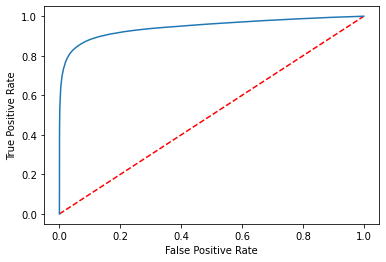

AUC =  0.9456292621248085


In [32]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Plot the ROC curve
modelSummary = model.summary
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Get the AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(prediction)
print ("AUC = ", auc)

In [62]:
import mlflow

modelpath = "abfss://files@datalakeyh4u3ae.dfs.core.windows.net/model/"
mlflow.spark.save_model(model, modelpath)
print("Model saved to ", modelpath)

StatementMeta(sparkyh4u3ae, 2, 61, Finished, Available)

Model saved to  abfss://files@datalakeyh4u3ae.dfs.core.windows.net/model/


In [71]:
from pyspark.sql.functions import col, pandas_udf,udf,lit
import azure.synapse.ml.predict as pcontext
from mlflow.utils import model_utils
import azure.synapse.ml.predict.utils._logger as synapse_predict_logger

StatementMeta(sparkyh4u3ae, 2, 70, Finished, Available)

In [72]:
#Set input data path
DATA_FILE = "/data/new-flights.csv"

#Set ADLS URI, if trained model is uploaded in ADLS
MODEL_URI = "abfss://files@datalakeyh4u3ae.dfs.core.windows.net/model/"

#Define model return type
RETURN_TYPES = "int" # for ex: int, float etc. PySpark data types are supported

#Define model runtime. This supports only mlflow
RUNTIME = "mlflow"

StatementMeta(sparkyh4u3ae, 2, 71, Finished, Available)

In [73]:
#Enable SynapseML predict
spark.conf.set("spark.synapse.ml.predict.enabled","true")

StatementMeta(sparkyh4u3ae, 2, 72, Finished, Available)

In [74]:
#Read data from ADLS
df = spark.read \
.format("csv") \
.option("header", "true") \
.csv(DATA_FILE,
    inferSchema=True)
df.createOrReplaceTempView('new_flights')

StatementMeta(sparkyh4u3ae, 2, 73, Finished, Available)

In [75]:
#Bind model within Spark session
mlflow_model = pcontext.bind_model(
    return_types=RETURN_TYPES, 
    runtime=RUNTIME, 
    model_alias="late", #This alias will be used in PREDICT call to refer  this   model
    model_uri=MODEL_URI #In case of AML, it will be AML_MODEL_URI
    ).register()

StatementMeta(sparkyh4u3ae, 2, 74, Finished, Available)

2022/07/13 23:52:52 INFO mlflow.spark: File '/tmp/tmpfpej3pig/sparkml' not found on DFS. Will attempt to upload the file.
2022/07/13 23:52:54 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/ed31d972-32cd-4e1e-bff2-a4321e2118b3


In [81]:
#Call PREDICT using Spark SQL API

predictions = spark.sql(
                """
                    SELECT predict("late", DayofMonth, DayOfWeek, CarrierIdx, OriginAirportID, DestAirportID, DepDelay) AS predict 
                    FROM new_flights
                """
            ).show()

StatementMeta(sparkyh4u3ae, 2, 80, Finished, Available)

AnalysisException: Undefined function: 'PREDICT_089001a35679a33ef3db0ca350db9b9a2f0136e0e327577b04b3b98127470961'. This function is neither a registered temporary function nor a permanent function registered in the database 'default'.; line 2 pos 27

In [78]:
#Call PREDICT using user defined function (UDF)

df = df["DayofMonth", "DayOfWeek", "Carrier", "OriginAirportID", "DestAirportID", "DepDelay"] # for ex. df["empid","empname"]

df.withColumn("PREDICT",mlflow_model.udf(lit("late"),*df.columns)).show()

StatementMeta(sparkyh4u3ae, 2, 77, Finished, Available)

AttributeError: 'PyFuncModel' object has no attribute 'udf'

In [79]:
#Call PREDICT using Transformer API

columns = ["DayofMonth", "DayOfWeek", "Carrier", "OriginAirportID", "DestAirportID", "DepDelay"] # for ex. df["empid","empname"]

tranformer = mlflow_model.create_transformer().setInputCols(columns).setOutputCol("PREDICT")

tranformer.transform(df).show()

StatementMeta(sparkyh4u3ae, 2, 78, Finished, Available)

AttributeError: 'PyFuncModel' object has no attribute 'create_transformer'

In [1]:
type(mlflow_model)

StatementMeta(, , , SessionError, )

AVAILABLE_COMPUTE_CAPACITY_EXCEEDED: Livy session has failed. Session state: Error. Error code: AVAILABLE_COMPUTE_CAPACITY_EXCEEDED. Your job requested 12 vcores. However, the pool only has 4 vcores available out of quota of 16 vcores. Try ending the running job(s) in the pool, reducing the numbers of vcores requested, increasing the pool maximum size or using another pool. Source: User.